# Using Langchain for Multi-Table Queries

## Introduction
In this notebook, we'll explore how Langchain can be efficiently used to query multiple tables.

## Case Study: Sales Analysis

### Dataset Description

We have a database containing three tables:

1. `sales`: Contains information about weekly sales.
2. `price`: Provides prices for products.
3. `descriptions`: Contains product information.

### Objective

Our goal is to analyze sales data and extract insights using human queries

## Importing Data

In [1]:
import pandas as pd

In [2]:
sales_df = pd.read_csv("data/sales.csv")

In [3]:
sales_df.head()

,item_id,unit,Sep1,Sep8,Sep15,Sep22,Sep29,Oct6,Oct13,Oct20,Oct27,Nov03,Nov10,Nov17,Nov24,Dec01,Dec08,Dec15,Dec22
0,u0000,kg,5.50,2.900,9.65,5.650,9.850,9.850,3.750,4.55,7.700,3.250,12.30,9.450,6.650,5.600,9.850,9.600,5.700
1,u0001,kg,1.76,7.568,10.56,3.872,8.712,2.288,7.128,8.80,10.472,1.408,11.00,8.008,5.016,4.752,7.568,8.624,8.624
2,u0002,kg,6.00,5.100,0.80,4.450,1.400,2.750,4.600,3.75,2.900,4.850,2.70,4.050,2.550,2.650,2.250,2.800,3.300
3,u0003,kg,3.55,9.500,5.45,4.750,7.900,4.400,7.650,6.60,5.450,5.900,2.80,7.900,4.600,5.250,8.250,2.700,8.900
4,u0004,kg,4.80,5.650,3.80,6.650,2.700,5.450,6.250,0.80,5.800,6.300,3.25,4.900,3.750,8.300,5.600,1.150,6.450


In [4]:
sales_df.drop(["unit"], axis=1, inplace=True)

In [5]:
price_df = pd.read_csv("data/price.csv")

In [6]:
price_df.head()

,item_id,price
0,u0000,12.0
1,u0001,10.0
2,u0002,15.0
3,u0003,8.0
4,u0004,15.0


In [7]:
description_df = pd.read_csv("data/description.csv")

In [8]:
description_df.head()

,item_id,Name,Category,Description
0,u0000,Apples,Fruits,"Sweet and crisp, a healthy snack choice."
1,u0001,Bananas,Fruits,Convenient and packed with natural energy.
2,u0002,Oranges,Fruits,Juicy and rich in vitamin C for a citrus burst.
3,u0003,Carrots,Vegetables,Crunchy and high in beta-carotene for eye health.
4,u0004,Broccoli,Vegetables,Nutrient-dense and versatile green vegetable.


In [9]:
sales_df.shape, price_df.shape, description_df.shape

((23, 18), (23, 2), (23, 4))

## Langchain time

In [10]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.indexes import VectorstoreIndexCreator

from langchain.llms import OpenAI
from langchain.agents import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType

In [11]:
from dotenv import load_dotenv
load_dotenv()

#import os
#os.environ["OPENAI_API_KEY"] ="sk-..."

True

In [12]:
file = 'data/sales.csv'
loader = CSVLoader(file_path=file)

### Index query

In [13]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

2023-10-16 11:40:29.148794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 11:40:29.255962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 11:40:30.367208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
query ="""
You are given a sales table with dates as columns and products as rows. 
What is the highest sold product?
"""

In [15]:
index.query(query)

'\nIt is not possible to answer this question without more information. The highest sold product depends on the unit of measurement (bottle, kg, etc.) and the quantity sold for each product.'

In [16]:
query ="""
You are given a sales table with dates as columns and products as rows. 
What is the highest sold product?
"""

### LLM with single dataframe

In [17]:
llm = OpenAI(temperature=0, model="text-davinci-003")

In [18]:
sales_df_agent = create_pandas_dataframe_agent(
    llm, sales_df.copy(), verbose=True, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

In [19]:
sales_df_agent.run(query)



> Entering new AgentExecutor chain...

Thought: I need to find the highest value in the table
Action: python_repl_ast
Action Input: df.max()
Observation: item_id    u0022
Sep1        16.0
Sep8        14.0
Sep15       19.0
Sep22       27.0
Sep29       22.0
Oct6        29.0
Oct13       26.0
Oct20       20.0
Oct27      37.75
Nov03       25.0
Nov10       21.0
Nov17       21.0
Nov24       24.0
Dec01       30.0
Dec08       18.0
Dec15        9.6
Dec22       17.0
dtype: object
Thought: I need to find the item_id associated with the highest value
Action: python_repl_ast
Action Input: df.loc[df['Sep1'].idxmax()]
Observation: item_id    u0012
Sep1        16.0
Sep8        14.0
Sep15       19.0
Sep22       27.0
Sep29       22.0
Oct6        29.0
Oct13       26.0
Oct20       20.0
Oct27       30.0
Nov03       25.0
Nov10       21.0
Nov17       21.0
Nov24       24.0
Dec01       30.0
Dec08       18.0
Dec15        6.0
Dec22       17.0
Name: 12, dtype: object
Thought: I now know the final answer
Final An

'The highest sold product is u0012.'

### LLM with multiple dataframes

In [20]:
query ="""
You are given a sales table with dates as columns and products as rows and a price table.
What product brings me the most revenue?
"""

In [21]:
sales_df_agent = create_pandas_dataframe_agent(
    llm, [sales_df.copy(), price_df.copy()], verbose=True, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

In [22]:
sales_df_agent.run(query)



> Entering new AgentExecutor chain...

Thought: I need to calculate the total revenue for each product
Action: python_repl_ast
Action Input: df1['total_revenue'] = df1.iloc[:,1:].mul(df2.price, axis=0).sum(axis=1)
Observation: 
Thought: I now know the total revenue for each product
Action: python_repl_ast
Action Input: df1['total_revenue'].idxmax()
Observation: 16
Thought: I now know the final answer
Final Answer: The product with the highest revenue is item_id u0016.

> Finished chain.


'The product with the highest revenue is item_id u0016.'

In [23]:
merged_df = pd.merge(sales_df, price_df, on='item_id')
date_columns = sales_df.columns[1:]
for column in date_columns:
    merged_df[column] = merged_df[column] * merged_df['price']

merged_df.drop(columns=['price'], inplace=True)

In [24]:
merged_df.head()

,item_id,Sep1,Sep8,Sep15,Sep22,Sep29,Oct6,Oct13,Oct20,Oct27,Nov03,Nov10,Nov17,Nov24,Dec01,Dec08,Dec15,Dec22
0,u0000,66.0,34.80,115.8,67.80,118.20,118.20,45.00,54.60,92.40,39.00,147.60,113.40,79.80,67.20,118.20,115.20,68.40
1,u0001,17.6,75.68,105.6,38.72,87.12,22.88,71.28,88.00,104.72,14.08,110.00,80.08,50.16,47.52,75.68,86.24,86.24
2,u0002,90.0,76.50,12.0,66.75,21.00,41.25,69.00,56.25,43.50,72.75,40.50,60.75,38.25,39.75,33.75,42.00,49.50
3,u0003,28.4,76.00,43.6,38.00,63.20,35.20,61.20,52.80,43.60,47.20,22.40,63.20,36.80,42.00,66.00,21.60,71.20
4,u0004,72.0,84.75,57.0,99.75,40.50,81.75,93.75,12.00,87.00,94.50,48.75,73.50,56.25,124.50,84.00,17.25,96.75


In [25]:
merged_df['item_id'][merged_df.sum(axis=1).idxmax()]

/tmp/ipykernel_140202/821040899.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df['item_id'][merged_df.sum(axis=1).idxmax()]


'u0016'

### Not Spooky Time Yet

In [26]:
item_ids = ["u0006", "u0019", "u0020"]

<Axes: >

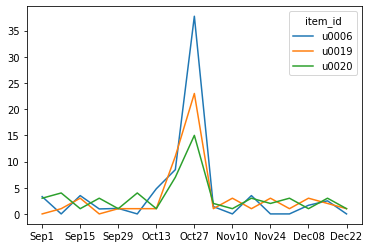

In [27]:
sales_df.set_index("item_id").loc[item_ids].T.plot()

In [28]:
description_df.set_index("item_id").loc[item_ids]

,Name,Category,Description
item_id,,,
u0006,Pumpkin,Vegetables,"Versatile squash, great for soups and pies."
u0019,Chocolate Bars,Snacks,"Decadent treat, enjoy in moderation."
u0020,Gummy Bears,Snacks,"Chewy, fruity sweets for occasional indulgence."


In [29]:
query ="""
I noticed there is a peak in sales for u0006, u0019 and u00210 
Can you explain why?"""

In [30]:
sales_df_agent = create_pandas_dataframe_agent(
    llm, [sales_df.copy(), price_df.copy(), description_df.copy()], 
    verbose=True, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

In [31]:
sales_df_agent.run(query)



> Entering new AgentExecutor chain...

Thought: I need to look at the dataframes to see what is different about these items
Action: python_repl_ast
Action Input: df1[df1['item_id'].isin(['u0006', 'u0019', 'u00210'])]
Observation:    item_id  Sep1  Sep8  Sep15  Sep22  Sep29  Oct6  Oct13  Oct20  Oct27  Nov03  \
6    u0006   3.3   0.0    3.5   0.95   1.05   0.0    4.8   8.45  37.75    1.4   
19   u0019   0.0   1.0    3.0   0.00   1.00   1.0    1.0  11.00  23.00    1.0   

    Nov10  Nov17  Nov24  Dec01  Dec08  Dec15  Dec22  
6     0.0    3.5    0.0    0.0   1.65    2.5    0.0  
19    3.0    1.0    3.0    1.0   3.00    2.0    1.0  
Thought: I can see that the sales for these items are higher in the later months
Action: python_repl_ast
Action Input: df2[df2['item_id'].isin(['u0006', 'u0019', 'u00210'])]
Observation:    item_id  price
6    u0006    8.0
19   u0019    8.0
Thought: The prices for these items are the same
Action: python_repl_ast
Action Input: df3[df3['item_id'].isin(['u0006', 

'The peak in sales for u0006, u0019 and u00210 is likely due to the fact that they are all different categories, which may have attracted more customers.'